In [1278]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [1280]:
# all the unique station in the provided dataset
unique_stations = ['FPZ_04A', 'FSB_126', 'FSB_079', 'FPZ_06A', 'FEX_004', 'FSB_078',
       'FSB_097D', 'FSB_130D', 'FSB_095DR']
finder = {}
for index, val in enumerate(unique_stations):
    finder[val]= index

finder

{'FPZ_04A': 0,
 'FSB_126': 1,
 'FSB_079': 2,
 'FPZ_06A': 3,
 'FEX_004': 4,
 'FSB_078': 5,
 'FSB_097D': 6,
 'FSB_130D': 7,
 'FSB_095DR': 8}

In [1282]:
index = 4
df = pd.read_csv(f"./data/{unique_stations[index]}.csv")
df = df.dropna()
print(df.shape)

(7366, 21)


In [1284]:
min_date = df["Date Time"].min()
min_date

1667946840000.0

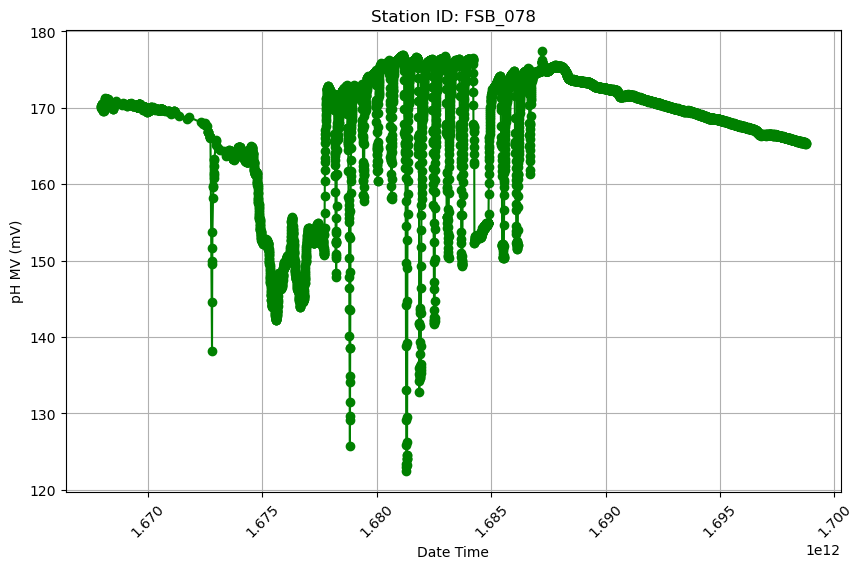

In [1286]:
plt.figure(figsize=(10, 6))
plt.plot(df['Date Time'], df['pH MV (mV)'], marker='o', color ="green")
plt.title(f'Station ID: FSB_078')
plt.xlabel('Date Time')
plt.ylabel('pH MV (mV)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [1288]:
num_of_months = 1
temp_months = num_of_months * 30 * 24 * 60 * 60 * 1000
first_temp_months = df[df["Date Time"] <= temp_months + min_date]
first_temp_months.shape

(286, 21)

In [1290]:
later_temp_months = df[df["Date Time"] > temp_months + min_date]
later_temp_months.shape

(7080, 21)

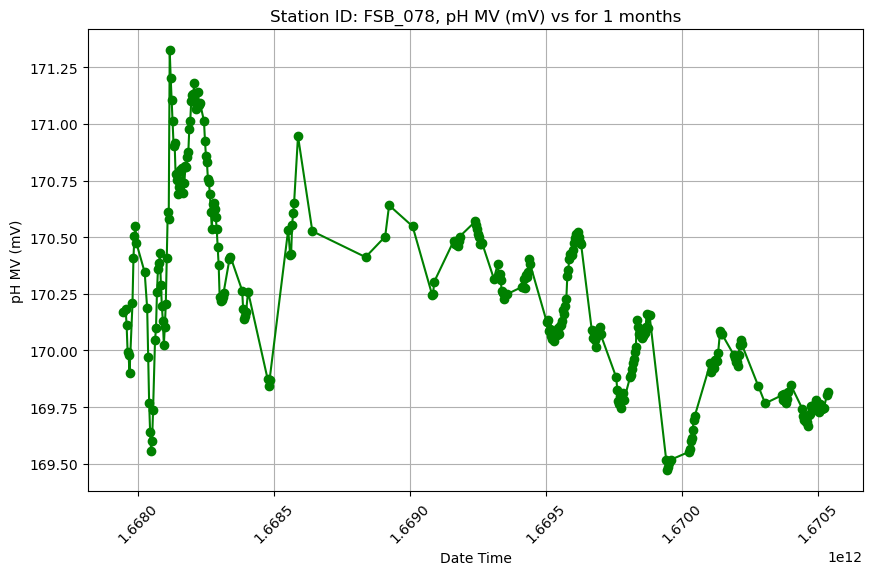

In [1292]:
plt.figure(figsize=(10, 6))
plt.plot(first_temp_months['Date Time'], first_temp_months['pH MV (mV)'], marker='o', color ="green")
plt.title(f'Station ID: FSB_078, pH MV (mV) vs for {num_of_months} months')
plt.xlabel('Date Time')
plt.ylabel('pH MV (mV)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [1294]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


In [1296]:
training_data_X = first_temp_months.drop(columns = ["station_id","Date Time","pH MV (mV)", "easting", "northing"])
training_data_y = first_temp_months["pH MV (mV)"].values.reshape(-1,1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

training_data_X = scaler_X.fit_transform(training_data_X)
training_data_y = scaler_y.fit_transform(training_data_y)

In [1298]:
test_data_X = later_temp_months.drop(columns = ["station_id","Date Time","pH MV (mV)","easting", "northing"])
test_data_y = later_temp_months["pH MV (mV)"].values.reshape(-1,1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

test_data_X = scaler_X.fit_transform(test_data_X)
test_data_y = scaler_y.fit_transform(test_data_y)

In [1300]:
X_train_tensor = torch.tensor(training_data_X, dtype=torch.float32)
y_train_tensor = torch.tensor(training_data_y, dtype=torch.float32)
print(f"shape of training X and y are {X_train_tensor.shape}, {y_train_tensor.shape}")

shape of training X and y are torch.Size([286, 16]), torch.Size([286, 1])


In [1302]:
X_test_tensor = torch.tensor(test_data_X, dtype=torch.float32)
y_test_tensor = torch.tensor(test_data_y, dtype=torch.float32)
print(f"shape of test X and y are {X_test_tensor.shape}, {y_test_tensor.shape}")

shape of test X and y are torch.Size([7080, 16]), torch.Size([7080, 1])


In [1304]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [1306]:
input_dim = training_data_X.shape[1]
output_dim = training_data_y.shape[1]

model = SimpleNN(input_dim, output_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [1308]:
num_epochs = 100

for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.0439
Epoch [20/100], Loss: 0.0044
Epoch [30/100], Loss: 0.0029
Epoch [40/100], Loss: 0.0011
Epoch [50/100], Loss: 0.0006
Epoch [60/100], Loss: 0.0006
Epoch [70/100], Loss: 0.0003
Epoch [80/100], Loss: 0.0003
Epoch [90/100], Loss: 0.0004
Epoch [100/100], Loss: 0.0002


In [1310]:
model.eval()  
with torch.no_grad():
    y_test_pred = model(X_test_tensor)
y_test_pred.shape

torch.Size([7080, 1])

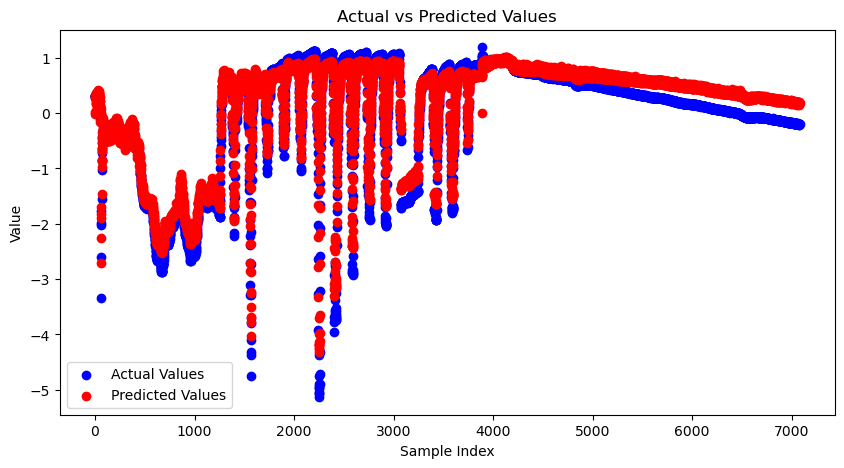

In [1312]:
plt.figure(figsize=(10, 5))
plt.scatter(range(len(y_test_tensor)), y_test_tensor, color='blue', label='Actual Values')
plt.scatter(range(len(y_test_pred)), y_test_pred, color='red', label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

In [1173]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 6),  # Input layer with 10 hidden units
            nn.ReLU(),
            nn.Linear(6, 3),  # Hidden layer with 16 hidden units
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(3, 6),
            nn.ReLU(),
            nn.Linear(6, input_dim)

         # nn.Sigmoi# Output layer with same dimension as input
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [1175]:
dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)

In [1177]:
model = Autoencoder(input_dim=16)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [1179]:
num_epochs = 100
losses = []
for epoch in range(num_epochs):
    for data in dataloader:
        inputs, _ = data
        
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    #appending the error to the losses array
    losses.append(loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 1.0475
Epoch [20/100], Loss: 0.6225
Epoch [30/100], Loss: 0.4252
Epoch [40/100], Loss: 0.3227
Epoch [50/100], Loss: 0.2380
Epoch [60/100], Loss: 0.1859
Epoch [70/100], Loss: 0.1752
Epoch [80/100], Loss: 0.1168
Epoch [90/100], Loss: 0.1452
Epoch [100/100], Loss: 0.1393


In [1207]:
model.eval()
with torch.no_grad():
    reconstructed_data = model(X_train_tensor)
    reconstruction_error = torch.mean((X_train_tensor - reconstructed_data) ** 2, axis=1).numpy()
print(len(reconstruction_error))
reconstruction_error

286


array([0.35098606, 0.02502113, 0.07587538, 0.01868007, 0.08199856,
       0.01822465, 0.1302258 , 0.04447268, 0.17003193, 0.06855573,
       0.10368776, 0.04817012, 0.22392386, 0.03284447, 0.05142231,
       0.11667427, 0.1318473 , 0.24087675, 0.09554097, 0.15385409,
       0.04740866, 0.04815454, 0.03512146, 0.01214994, 0.01316717,
       0.07010442, 0.31450158, 0.05110234, 0.07509686, 0.07385833,
       0.16503721, 0.03787424, 0.04331274, 0.01106334, 0.1764448 ,
       0.05899145, 0.08382621, 0.02740517, 0.06312609, 0.05287554,
       0.01174441, 0.02113968, 0.01278013, 0.01658533, 0.04573749,
       0.06539367, 0.02750903, 0.20838869, 0.09072217, 0.07573944,
       0.06759132, 0.06155461, 0.03034569, 0.0600775 , 0.06343484,
       0.18782748, 0.03059191, 0.07065455, 0.04000818, 0.1979166 ,
       0.08037369, 0.20716427, 0.05088594, 0.06505355, 0.23626868,
       0.21934429, 0.09464375, 0.05130298, 0.0552686 , 0.07881543,
       0.0762175 , 0.09656649, 0.12658076, 0.10135937, 0.07175

In [1209]:
threshold = np.mean(reconstruction_error) + 2 * np.std(reconstruction_error)
threshold

0.32349149882793427

In [1211]:
anomalies = reconstruction_error > threshold
print(len(anomalies))
anomalies

286


array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False,  True,

In [1213]:
print(f'Number of anomalies detected: {np.sum(anomalies)}')

Number of anomalies detected: 16


In [1199]:
model.eval()
with torch.no_grad():
    reconstructed_data = model(X_test_tensor)
    reconstruction_error = torch.mean((X_test_tensor - reconstructed_data) ** 2, axis=1).numpy()
print(len(reconstruction_error))
reconstruction_error

7080


array([1.3787609 , 1.3808285 , 1.6351436 , ..., 0.81847847, 0.81343067,
       0.7157526 ], dtype=float32)

In [1201]:
threshold = np.mean(reconstruction_error) + 2 * np.std(reconstruction_error)
threshold

1.6073943972587585

In [1203]:
anomalies = reconstruction_error > threshold
print(len(anomalies))
anomalies

7080


array([False, False,  True, ..., False, False, False])

In [1205]:
print(f'Number of anomalies detected: {np.sum(anomalies)}')

Number of anomalies detected: 469
